<a href="https://colab.research.google.com/github/superahxd/_project/blob/main/sec4/sec4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

프로젝트

- kaggle 트위터 데이터셋으로 lstm 학습
- DokeV 감정분석해보기

column 설명
```
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
```

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install nltk

     |████████████████████████████████| 24.0 MB 87 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 11.3 MB 26.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


In [2]:
# kaggle tweet set 불러오기

!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leeaehyun","key":"99d2da7d46a0dc70431d637248f37278"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d kazanova/sentiment140

 91% 74.0M/80.9M [00:00<00:00, 103MB/s] 
100% 80.9M/80.9M [00:00<00:00, 138MB/s]


In [5]:
! unzip -qq "/content/sentiment140.zip"

In [34]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

print(dataset)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          4  Just woke up. Having no school is the best fee...
1599996          4  TheWDB.com - Very cool to hear old Walt interv...
1599997          4  Are you ready for your MoJo Makeover? Ask me f...
1599998          4  Happy 38th Birthday to my boo of alll time!!! ...
1599999          4  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


In [36]:
dataset['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [37]:
# 4를 1로 바꾼다. 1=positive , 0=negative
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

print(dataset)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


In [38]:
import random
random_idx_list = [random.randint(1,len(dataset.text)) for i in range(10)] # creates random indexes to choose from dataframe
print(dataset.loc[random_idx_list,:].head(10)) # Returns the rows with the index and display it

         sentiment                                               text
690438           0  @handcircus why isn't the next Rolando 2 video...
226331           0             bored  all i can do is watch dvds, zz.
51979            0                 @TheRopolitans feel better Andrew 
180809           0  Today was a really good day.Geetay's makeup tu...
880362           1  @funkyfreshnik nikki, sorry, i left the mall a...
1311082          1  @michelly023 ur watching rush hour 3 arent you...
1264333          1  @bigsmooth433430 I heard you abused my poor, h...
1132602          1                     @skillzva ahhh! That's it ... 
1520877          1  @Amelia_Grace Yeah sure did I'm coming in to o...
472446           0  @NatalyaFGM it's crap isn't it. i've taken som...


Text(0.5, 1.0, 'Sentiment Data Distribution')

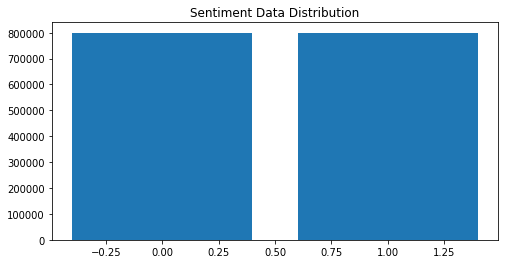

In [39]:
val_count = dataset.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [40]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk

nltk.download('stopwords')

stopwordlist = stopwords.words('english')
stemmer = SnowballStemmer('english')
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer. 표제어 추출하기
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns. 정규식 패턴
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" #http, www, https로 시작하는 url 제거
    userPattern       = '@[^\s]+' #@으로 시작하는 유저 아이디 제거
    alphaPattern      = "[^a-zA-Z]" #영어 대소문자 외 제거
    sequencePattern   = r"(.)\1\1+" #
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [42]:
import time

nltk.download('wordnet')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Text Preprocessing complete.
Time Taken: 142 seconds


In [43]:
processedtext = pd.DataFrame(processedtext)
print(processedtext)

                                                         0
0        USER URL aww that bummer you shoulda got david...
1        is upset that he can update his facebook by te...
2        USER dived many time for the ball managed to s...
3            my whole body feel itchy and like it on fire 
4        USER no it not behaving at all mad why am here...
...                                                    ...
1599995  just woke up having no school is the best feel...
1599996  thewdb com very cool to hear old walt intervie...
1599997  are you ready for your mojo makeover ask me fo...
1599998  happy th birthday to my boo of all time tupac ...
1599999               happy charitytuesday USER USER USER 

[1600000 rows x 1 columns]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0, )
print(f'Data Split done.')

Data Split done.


In [45]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000, decode_error='ignore')
vectoriser.fit(X_train[0])
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [46]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

AttributeError: ignored

In [ ]:
import spacy
from keras.preprocessing.text import Tokenizer
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenize = Tokenizer(nlp.vocab)

max_words = 3000
max_len = 400
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers